평가문항	상세기준

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?	


    ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.


2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?	


    CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.


3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?


    CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) 
    return cam_image

In [4]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


In [18]:
import os
print(os.getcwd())

/aiffel/aiffel/class_actiavtion_map


In [29]:
import os
cam_model_path = '/aiffel/aiffel/class_actiavtion_map/cam_model1.h5'
print("파일 존재 여부:", os.path.exists(cam_model_path))
cam_model = tf.keras.models.load_model(cam_model_path)

파일 존재 여부: True


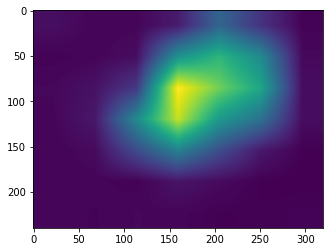

In [31]:
item = get_one(ds_test)
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [32]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

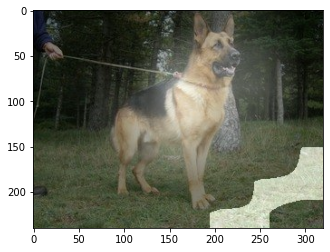

In [36]:
import numpy

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [38]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


116


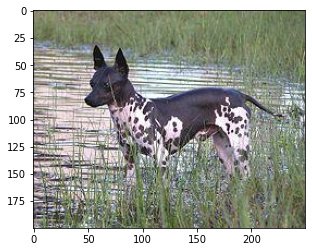

In [39]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [43]:
cam_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.
위에 cam_model.summary() 에서 확인하기!

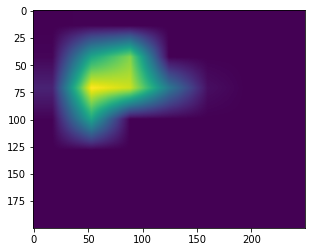

In [40]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item) #마지막 출력층
plt.imshow(grad_cam_image)
plt.show()

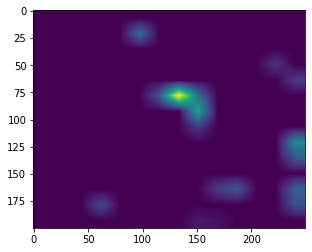

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item) #중간 출력층
plt.imshow(grad_cam_image)
plt.show()

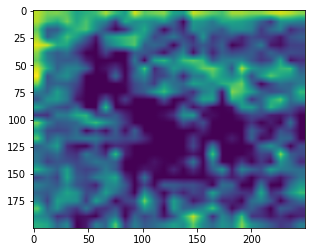

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item) #중간 출력층?
plt.imshow(grad_cam_image)
plt.show()

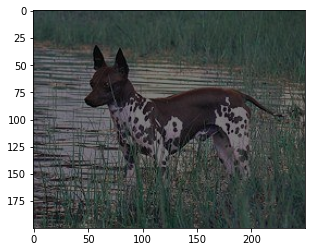

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# grad_cam_image가 그레이스케일이면 BGR로 변환
if len(grad_cam_image.shape) == 2:
    grad_cam_image = cv2.cvtColor(grad_cam_image, cv2.COLOR_GRAY2BGR)

# 두 이미지의 데이터 타입을 맞추기 (uint8)
origin_image_uint8 = origin_image.astype(np.uint8)
grad_cam_image_uint8 = grad_cam_image.astype(np.uint8)

alpha = 0.5  # 가중치 값
blended_image = cv2.addWeighted(grad_cam_image_uint8, alpha, origin_image_uint8, 1 - alpha, 0.0)

plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.show()





108


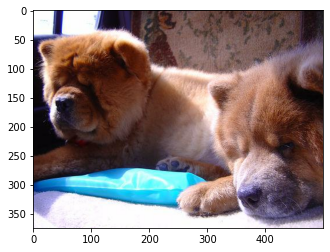

In [55]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

출력층은 마지막에 있는걸 쓰는게 일반적이라 느껴서 사용하였습니다.

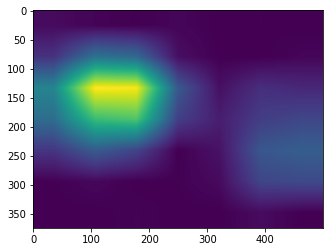

In [63]:
cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
plt.imshow(cam_image)
plt.show()

In [117]:
def get_bbox(cam_image, score_thresh=0.5):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [65]:
rect = get_bbox(cam_image)
rect

array([[-38, 270],
       [  5,   4],
       [538,  91],
       [495, 358]])

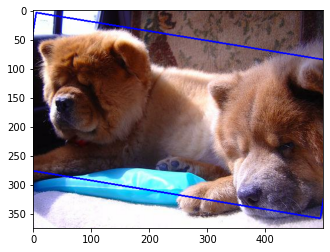

In [66]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [67]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [68]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.010666666666666666, -0.076, 0.9546666666666667, 1.076]

In [71]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [72]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.38450839538550186

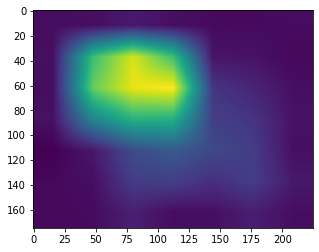

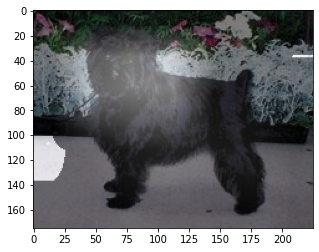

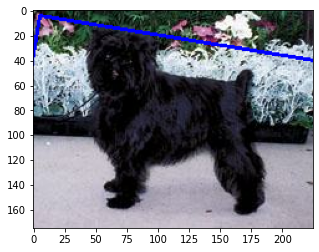

0.11330822648448963

In [75]:
item = get_one(ds_test)
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compare(cam_model, ds_test, gradcam_layer="conv5_block3_out"):
    # 1. 하나의 테스트 샘플 가져오기
    item = get_one(ds_test)
    origin_image = item['image'].astype(np.uint8)
    
    # 2. 기존 CAM 생성 및 시각화
    cam_image = generate_cam(cam_model, item)
    plt.imshow(cam_image, cmap='jet')
    plt.title("CAM")
    plt.show()
    
    cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)
    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    plt.imshow(blended_image)
    plt.title("CAM Blended")
    plt.show()
    
    # 3. Grad-CAM 생성 (출력 레이어 옵션 적용) 및 시각화
    grad_cam_image = generate_grad_cam(cam_model, gradcam_layer, item)
    plt.imshow(grad_cam_image, cmap='jet')
    plt.title("Grad-CAM (Layer: {})".format(gradcam_layer))
    plt.show()
    
    grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
    blended_grad_cam = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
    plt.imshow(blended_grad_cam)
    plt.title("Grad-CAM Blended (Layer: {})".format(gradcam_layer))
    plt.show()
    
    # 4. Bounding Box 및 IoU 계산
    # CAM 영역에서 bounding box 추출 및 IoU 계산
    cam_rect = get_bbox(cam_image)  
    cam_bbox = rect_to_minmax(cam_rect, item['image'])
    iou_cam = get_iou(cam_bbox, item['objects']['bbox'][0])
    print("CAM IoU:", iou_cam)
    
    # Grad-CAM 영역에서 bounding box 추출 및 IoU 계산
    grad_cam_rect = get_bbox(grad_cam_image)  
    grad_cam_bbox = rect_to_minmax(grad_cam_rect, item['image'])
    iou_grad_cam = get_iou(grad_cam_bbox, item['objects']['bbox'][0])
    print("Grad-CAM IoU (Layer: {}):".format(gradcam_layer), iou_grad_cam)


# 다른 출력 레이어 사용: evaluate_cam_methods(cam_model, ds_test, gradcam_layer="conv4_block6_out")




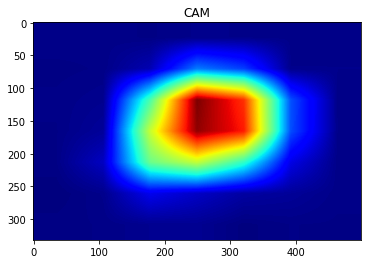

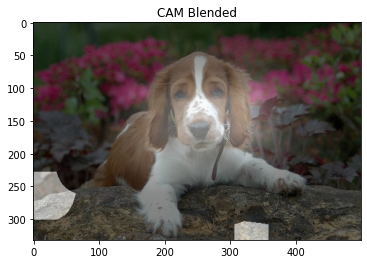

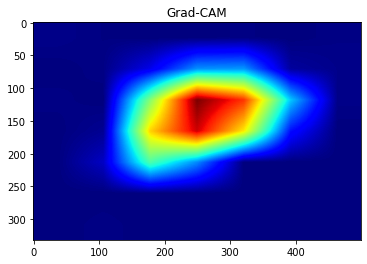

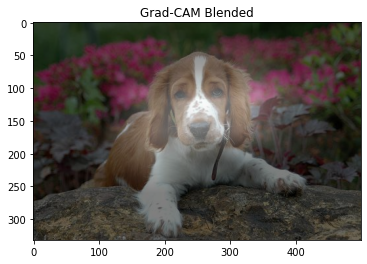

CAM IoU: 0.655025850681554
Grad-CAM IoU: 0.6071632828349994


In [85]:
compare(cam_model, ds_test)

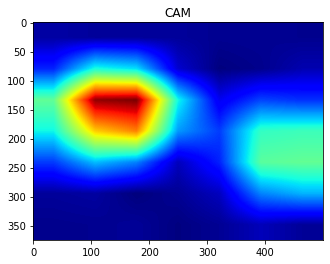

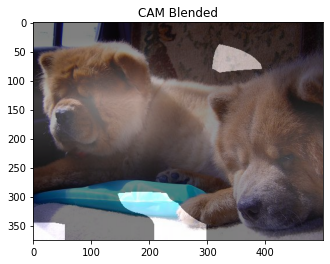

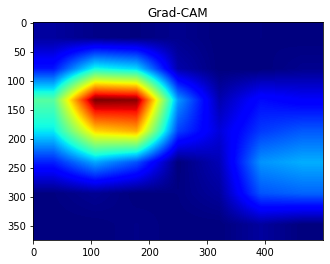

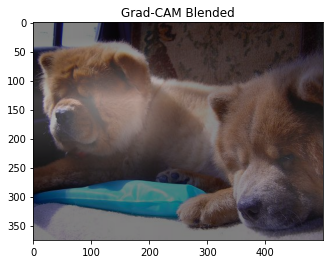

CAM IoU: 0.38404543558158705
Grad-CAM IoU: 0.38450839538550186


In [86]:
compare(cam_model, ds_test)

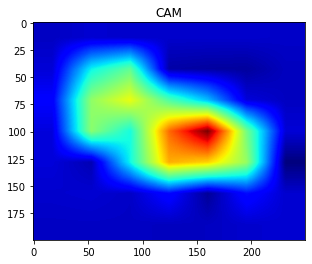

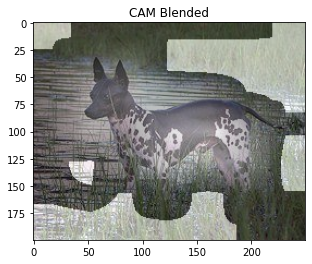

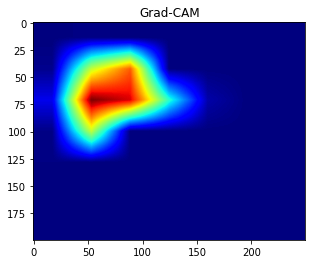

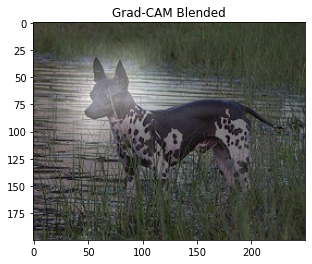

CAM IoU: 0.42257900064462073
Grad-CAM IoU: 0.3206849672252532


In [87]:
compare(cam_model, ds_test)

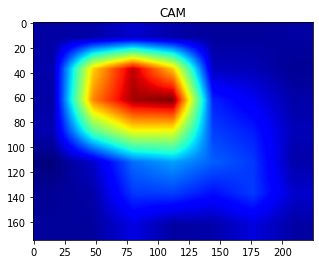

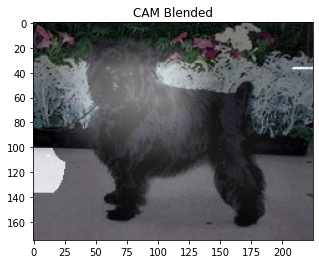

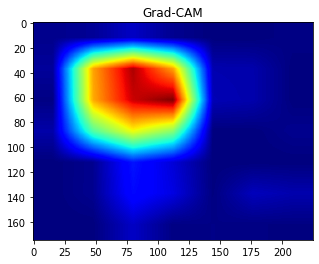

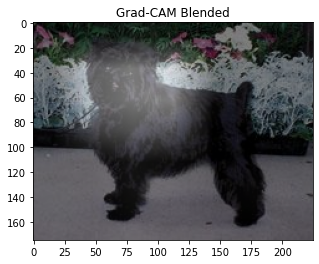

CAM IoU: 0.7680851267650723
Grad-CAM IoU: 0.0016880193457880243


In [88]:
compare(cam_model, ds_test)

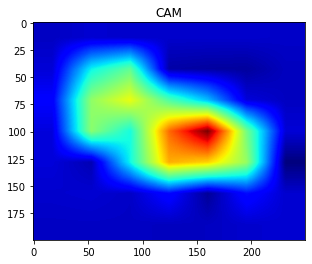

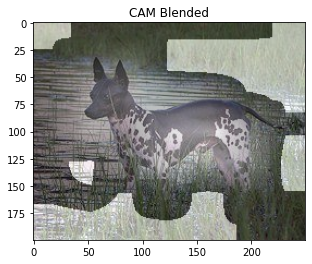

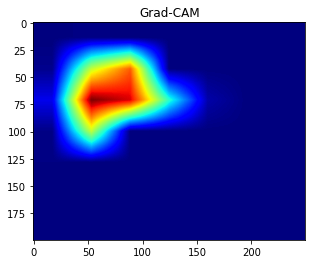

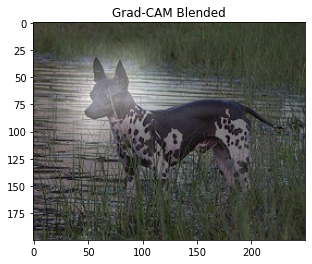

CAM IoU: 0.42257900064462073
Grad-CAM IoU: 0.3206849672252532


In [89]:
compare(cam_model, ds_test)

비교 결과 : 대부분 IOU점수가 그냥 CAM이 더 잘나온다.


질문 : 왜 CAM이 성능이 더 좋은가

IOU가 높으면 성능이 더 좋은게 확실한가?

Grad_CAM의 출력 레이어를 바꾸면 Grad_CAM의 성능이 더 좋을때도 있을까?

def get_bbox(cam_image, score_thresh=0.05)에서 thresh 부분을 조정해보는 것도 시도.



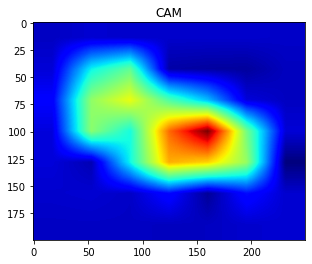

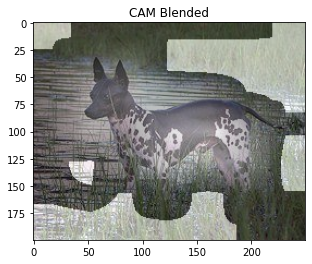

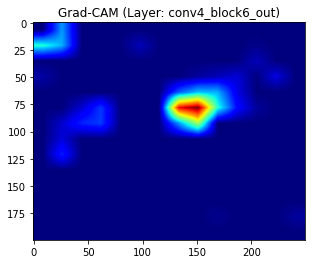

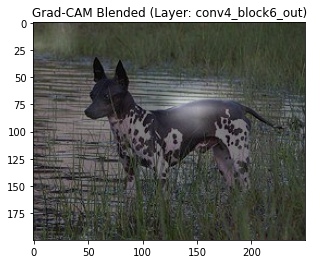

CAM IoU: 0.42257900064462073
Grad-CAM IoU (Layer: conv4_block6_out): 0.09834775683497278


In [100]:
compare(cam_model, ds_test, gradcam_layer="conv4_block6_out")

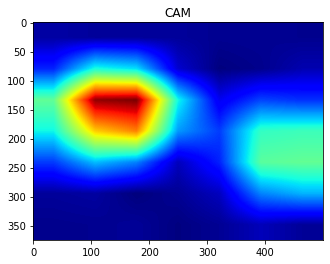

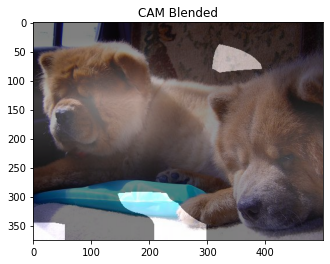

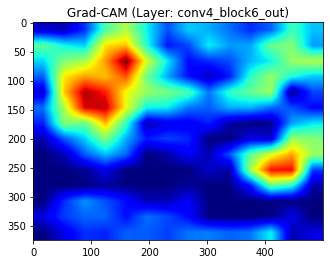

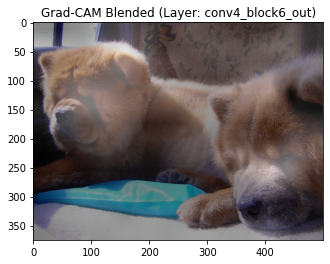

CAM IoU: 0.38404543558158705
Grad-CAM IoU (Layer: conv4_block6_out): 0.18972672719098208


In [102]:
compare(cam_model, ds_test, gradcam_layer="conv4_block6_out")

conv4_block6_out layer 변경 후 IOU 점수가 더 떨어짐 

쓰레쉬홀드 0.2로 변경

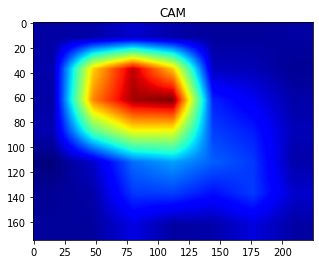

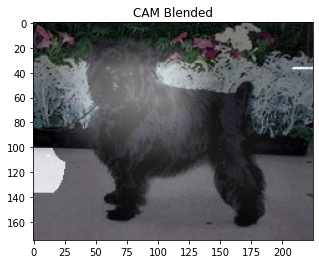

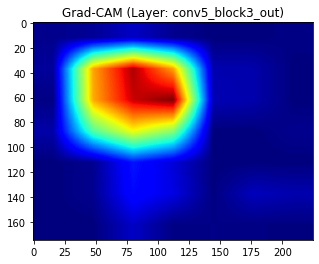

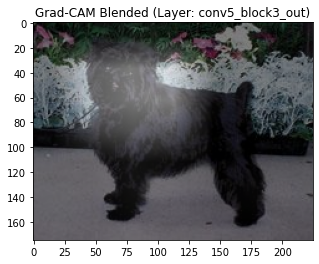

CAM IoU: 0.49889374514294
Grad-CAM IoU (Layer: conv5_block3_out): 0.40912009189071685


In [108]:
compare(cam_model, ds_test, gradcam_layer="conv5_block3_out")

CAM IoU: 0.7680851267650723
Grad-CAM IoU: 0.0016880193457880243
    
-> 0.2 조정 후

CAM IoU: 0.49889374514294
Grad-CAM IoU (Layer: conv5_block3_out): 0.40912009189071685

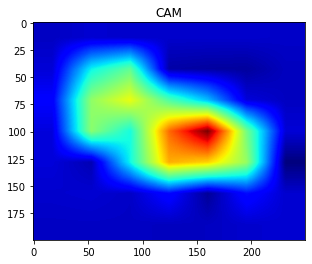

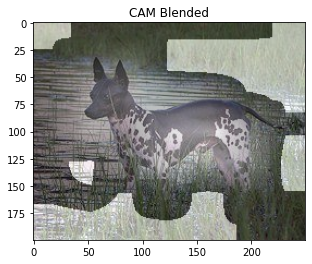

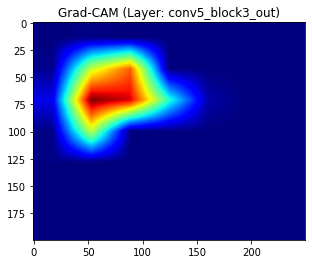

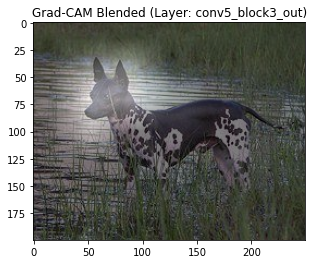

CAM IoU: 0.5891534315649223
Grad-CAM IoU (Layer: conv5_block3_out): 0.27203525096283643


In [115]:
compare(cam_model, ds_test, gradcam_layer="conv5_block3_out")

CAM IoU: 0.42257900064462073
Grad-CAM IoU: 0.3206849672252532 

-> 변경 후

CAM IoU: 0.5891534315649223
Grad-CAM IoU (Layer: conv5_block3_out): 0.27203525096283643

개선 된 것도 있고 오히려 떨어진 경우도 있어서 확실하게 비교가 어렵다. 조금 더 테스트 해봐야겠다. 0.5로 변경해서 진행

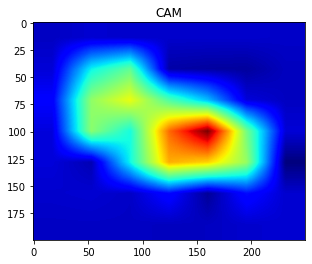

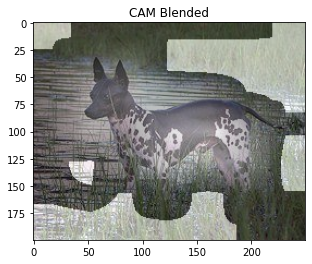

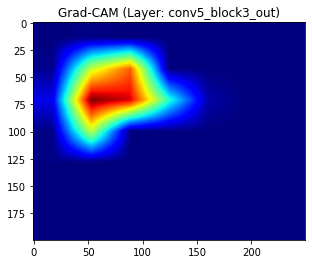

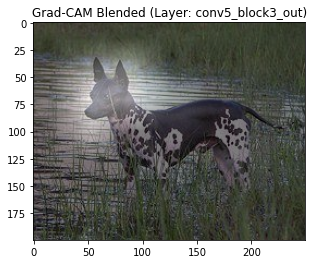

CAM IoU: 0.722768932306652
Grad-CAM IoU (Layer: conv5_block3_out): 0.18848882193957556


In [118]:
compare(cam_model, ds_test, gradcam_layer="conv5_block3_out")

CAM IoU: 0.42257900064462073 Grad-CAM IoU: 0.3206849672252532

-> 변경 후

CAM IoU: 0.5891534315649223 Grad-CAM IoU (Layer: conv5_block3_out): 0.27203525096283643
        
->

CAM IoU: 0.722768932306652
Grad-CAM IoU (Layer: conv5_block3_out): 0.18848882193957556

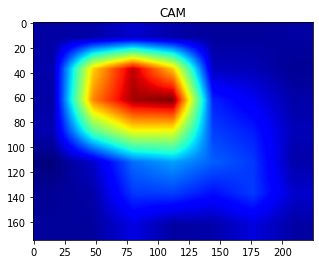

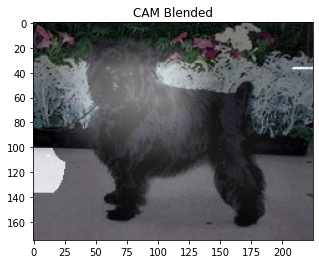

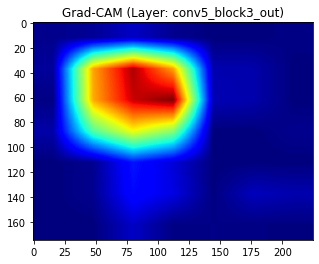

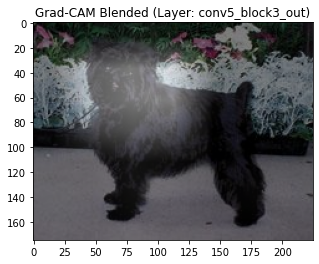

CAM IoU: 0.31978133561911354
Grad-CAM IoU (Layer: conv5_block3_out): 0.268784618906247


In [121]:
compare(cam_model, ds_test, gradcam_layer="conv5_block3_out")

CAM IoU: 0.7680851267650723
Grad-CAM IoU: 0.0016880193457880243
    
-> 0.2 조정 후

CAM IoU: 0.49889374514294
Grad-CAM IoU (Layer: conv5_block3_out): 0.40912009189071685
    
-> 0.5 조정 후

CAM IoU: 0.31978133561911354
Grad-CAM IoU (Layer: conv5_block3_out): 0.268784618906247


# 회고록

중간에 오류가 나서 실험을 좀 많이 못했다. 괜한 자존심 부리지말고 사람들한테 물어보기도 하자.

grad_cam이 cam보다 왜 성능이 더 떨어져보일까를 생각해보는게 이번 문제였는데

첫번째로는 IOU점수로만 성능이 안좋다고 할 수 있을까?를 좀 더 생각해보고

두번째로는 grad_cam특성상 어쩔수 없이 성능이 안좋게 나올 수 있지도 않을까를 조금 더 고려해보고

세번째로는 지금 이 모델에서 성능을 높일 수 있는 방법을 조금 더 생각해야 겠습니다.(레이어 바꾸기, 쓰레쉬홀드 값 조정하기)

